In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 829)
(663976, 1)
validation
(128936, 829)
(128936, 1)
test
(61376, 829)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:26 - loss: 0.0700 - STD: 9.2078e-05 - MAE: 0.2456

 4/67 [>.............................] - ETA: 1s - loss: 0.0303 - STD: 2.6625e-04 - MAE: 0.1358  

 5/67 [=>............................] - ETA: 2s - loss: 0.0295 - STD: 2.4862e-04 - MAE: 0.1339

 6/67 [=>............................] - ETA: 2s - loss: 0.0293 - STD: 2.3070e-04 - MAE: 0.1335

 7/67 [==>...........................] - ETA: 2s - loss: 0.0292 - STD: 2.1500e-04 - MAE: 0.1334

 8/67 [==>...........................] - ETA: 2s - loss: 0.0289 - STD: 2.0191e-04 - MAE: 0.1327

 9/67 [===>..........................] - ETA: 2s - loss: 0.0284 - STD: 1.9120e-04 - MAE: 0.1312

10/67 [===>..........................] - ETA: 2s - loss: 0.0277 - STD: 1.8281e-04 - MAE: 0.1289

11/67 [===>..........................] - ETA: 3s - loss: 0.0268 - STD: 1.7669e-04 - MAE: 0.1259

12/67 [====>.........................] - ETA: 3s - loss: 0.0258 - STD: 1.7227e-04 - MAE: 0.1228

13/67 [====>.........................] - ETA: 2s - loss: 0.0247 - STD: 1.6957e-04 - MAE: 0.1196

14/67 [=====>........................] - ETA: 2s - loss: 0.0238 - STD: 1.6799e-04 - MAE: 0.1170

15/67 [=====>........................] - ETA: 2s - loss: 0.0230 - STD: 1.6716e-04 - MAE: 0.1151

16/67 [======>.......................] - ETA: 2s - loss: 0.0224 - STD: 1.6704e-04 - MAE: 0.1140

17/67 [======>.......................] - ETA: 2s - loss: 0.0219 - STD: 1.6753e-04 - MAE: 0.1134

18/67 [=======>......................] - ETA: 2s - loss: 0.0216 - STD: 1.6849e-04 - MAE: 0.1132

19/67 [=======>......................] - ETA: 2s - loss: 0.0213 - STD: 1.7004e-04 - MAE: 0.1128

20/67 [=======>......................] - ETA: 2s - loss: 0.0209 - STD: 1.7200e-04 - MAE: 0.1123

21/67 [========>.....................] - ETA: 2s - loss: 0.0205 - STD: 1.7436e-04 - MAE: 0.1114

22/67 [========>.....................] - ETA: 2s - loss: 0.0201 - STD: 1.7689e-04 - MAE: 0.1104

23/67 [=========>....................] - ETA: 3s - loss: 0.0200 - STD: 1.7930e-04 - MAE: 0.1094

26/67 [==========>...................] - ETA: 3s - loss: 0.0190 - STD: 1.8613e-04 - MAE: 0.1062

28/67 [===========>..................] - ETA: 2s - loss: 0.0185 - STD: 1.9036e-04 - MAE: 0.1045

29/67 [===========>..................] - ETA: 2s - loss: 0.0183 - STD: 1.9262e-04 - MAE: 0.1037

30/67 [============>.................] - ETA: 2s - loss: 0.0181 - STD: 1.9503e-04 - MAE: 0.1030

31/67 [============>.................] - ETA: 2s - loss: 0.0179 - STD: 1.9769e-04 - MAE: 0.1023

32/67 [=============>................] - ETA: 2s - loss: 0.0177 - STD: 2.0060e-04 - MAE: 0.1016

33/67 [=============>................] - ETA: 2s - loss: 0.0176 - STD: 2.0385e-04 - MAE: 0.1011

34/67 [==============>...............] - ETA: 2s - loss: 0.0174 - STD: 2.0744e-04 - MAE: 0.1005

35/67 [==============>...............] - ETA: 2s - loss: 0.0172 - STD: 2.1125e-04 - MAE: 0.1000

36/67 [===============>..............] - ETA: 2s - loss: 0.0170 - STD: 2.1528e-04 - MAE: 0.0996

37/67 [===============>..............] - ETA: 2s - loss: 0.0169 - STD: 2.1954e-04 - MAE: 0.0993

38/67 [================>.............] - ETA: 2s - loss: 0.0167 - STD: 2.2395e-04 - MAE: 0.0990

39/67 [================>.............] - ETA: 1s - loss: 0.0166 - STD: 2.2857e-04 - MAE: 0.0987

40/67 [================>.............] - ETA: 1s - loss: 0.0165 - STD: 2.3326e-04 - MAE: 0.0985

41/67 [=================>............] - ETA: 1s - loss: 0.0164 - STD: 2.3796e-04 - MAE: 0.0983

42/67 [=================>............] - ETA: 1s - loss: 0.0163 - STD: 2.4275e-04 - MAE: 0.0980

43/67 [==================>...........] - ETA: 1s - loss: 0.0162 - STD: 2.4756e-04 - MAE: 0.0977

44/67 [==================>...........] - ETA: 1s - loss: 0.0161 - STD: 2.5236e-04 - MAE: 0.0974

45/67 [===================>..........] - ETA: 1s - loss: 0.0160 - STD: 2.5711e-04 - MAE: 0.0972

47/67 [====================>.........] - ETA: 1s - loss: 0.0158 - STD: 2.6671e-04 - MAE: 0.0965

48/67 [====================>.........] - ETA: 1s - loss: 0.0157 - STD: 2.7164e-04 - MAE: 0.0962

49/67 [====================>.........] - ETA: 1s - loss: 0.0156 - STD: 2.7670e-04 - MAE: 0.0959

50/67 [=====================>........] - ETA: 1s - loss: 0.0155 - STD: 2.8173e-04 - MAE: 0.0956

51/67 [=====================>........] - ETA: 1s - loss: 0.0154 - STD: 2.8697e-04 - MAE: 0.0954

52/67 [======================>.......] - ETA: 1s - loss: 0.0153 - STD: 2.9238e-04 - MAE: 0.0951

53/67 [======================>.......] - ETA: 0s - loss: 0.0152 - STD: 2.9803e-04 - MAE: 0.0949

54/67 [=======================>......] - ETA: 0s - loss: 0.0152 - STD: 3.0399e-04 - MAE: 0.0947

55/67 [=======================>......] - ETA: 0s - loss: 0.0151 - STD: 3.1025e-04 - MAE: 0.0945

56/67 [========================>.....] - ETA: 0s - loss: 0.0150 - STD: 3.1676e-04 - MAE: 0.0943

57/67 [========================>.....] - ETA: 0s - loss: 0.0150 - STD: 3.2373e-04 - MAE: 0.0941

58/67 [========================>.....] - ETA: 0s - loss: 0.0149 - STD: 3.3087e-04 - MAE: 0.0940

59/67 [=========================>....] - ETA: 0s - loss: 0.0149 - STD: 3.3826e-04 - MAE: 0.0938

60/67 [=========================>....] - ETA: 0s - loss: 0.0148 - STD: 3.4584e-04 - MAE: 0.0937

61/67 [==========================>...] - ETA: 0s - loss: 0.0147 - STD: 3.5364e-04 - MAE: 0.0935

62/67 [==========================>...] - ETA: 0s - loss: 0.0147 - STD: 3.6152e-04 - MAE: 0.0934

63/67 [===========================>..] - ETA: 0s - loss: 0.0146 - STD: 3.6975e-04 - MAE: 0.0933

64/67 [===========================>..] - ETA: 0s - loss: 0.0146 - STD: 3.7807e-04 - MAE: 0.0931

65/67 [============================>.] - ETA: 0s - loss: 0.0145 - STD: 3.8650e-04 - MAE: 0.0930

66/67 [============================>.] - ETA: 0s - loss: 0.0145 - STD: 3.9517e-04 - MAE: 0.0928

67/67 [==============================] - ETA: 0s - loss: 0.0144 - STD: 4.0430e-04 - MAE: 0.0927

67/67 [==============================] - 7s 80ms/step - loss: 0.0144 - STD: 4.0430e-04 - MAE: 0.0927 - val_loss: 0.0102 - val_STD: 7.8189e-04 - val_MAE: 0.0798


Epoch 2/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0111 - STD: 0.0010 - MAE: 0.0818

 2/67 [..............................] - ETA: 4s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0827

 3/67 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 0.0011 - MAE: 0.0827

 4/67 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 0.0011 - MAE: 0.0828

 5/67 [=>............................] - ETA: 4s - loss: 0.0114 - STD: 0.0011 - MAE: 0.0828

 6/67 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0829

 7/67 [==>...........................] - ETA: 3s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0829

 8/67 [==>...........................] - ETA: 3s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0830

 9/67 [===>..........................] - ETA: 3s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0832

10/67 [===>..........................] - ETA: 3s - loss: 0.0114 - STD: 0.0013 - MAE: 0.0833

11/67 [===>..........................] - ETA: 3s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0833

12/67 [====>.........................] - ETA: 3s - loss: 0.0114 - STD: 0.0013 - MAE: 0.0834

13/67 [====>.........................] - ETA: 3s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0834

14/67 [=====>........................] - ETA: 3s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0834

15/67 [=====>........................] - ETA: 3s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0835

16/67 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0835

17/67 [======>.......................] - ETA: 3s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0835

18/67 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0835

19/67 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0835

20/67 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 0.0016 - MAE: 0.0834

21/67 [========>.....................] - ETA: 2s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0835

22/67 [========>.....................] - ETA: 2s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0835

23/67 [=========>....................] - ETA: 2s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0834

24/67 [=========>....................] - ETA: 2s - loss: 0.0113 - STD: 0.0018 - MAE: 0.0833

25/67 [==========>...................] - ETA: 2s - loss: 0.0113 - STD: 0.0019 - MAE: 0.0833

26/67 [==========>...................] - ETA: 2s - loss: 0.0113 - STD: 0.0020 - MAE: 0.0833

27/67 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 0.0020 - MAE: 0.0833

28/67 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 0.0021 - MAE: 0.0833

29/67 [===========>..................] - ETA: 2s - loss: 0.0113 - STD: 0.0022 - MAE: 0.0833

30/67 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 0.0022 - MAE: 0.0833

31/67 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 0.0023 - MAE: 0.0833

32/67 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 0.0024 - MAE: 0.0832

33/67 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 0.0025 - MAE: 0.0832

34/67 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 0.0026 - MAE: 0.0832

35/67 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 0.0027 - MAE: 0.0832

36/67 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 0.0028 - MAE: 0.0832

37/67 [===============>..............] - ETA: 1s - loss: 0.0112 - STD: 0.0029 - MAE: 0.0831

38/67 [================>.............] - ETA: 1s - loss: 0.0112 - STD: 0.0030 - MAE: 0.0831

39/67 [================>.............] - ETA: 1s - loss: 0.0111 - STD: 0.0031 - MAE: 0.0830

40/67 [================>.............] - ETA: 1s - loss: 0.0111 - STD: 0.0032 - MAE: 0.0830

41/67 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 0.0034 - MAE: 0.0830

42/67 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 0.0035 - MAE: 0.0829

43/67 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 0.0037 - MAE: 0.0829

44/67 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 0.0038 - MAE: 0.0829

45/67 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 0.0040 - MAE: 0.0828

46/67 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 0.0042 - MAE: 0.0828

47/67 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 0.0044 - MAE: 0.0828

48/67 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 0.0046 - MAE: 0.0827

49/67 [====================>.........] - ETA: 1s - loss: 0.0110 - STD: 0.0048 - MAE: 0.0826

50/67 [=====================>........] - ETA: 1s - loss: 0.0110 - STD: 0.0051 - MAE: 0.0826

51/67 [=====================>........] - ETA: 1s - loss: 0.0110 - STD: 0.0053 - MAE: 0.0825

53/67 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 0.0058 - MAE: 0.0824

54/67 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 0.0061 - MAE: 0.0823

55/67 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 0.0064 - MAE: 0.0822

56/67 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 0.0067 - MAE: 0.0821

57/67 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 0.0071 - MAE: 0.0820

58/67 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 0.0074 - MAE: 0.0820

59/67 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0077 - MAE: 0.0819

60/67 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0081 - MAE: 0.0818

61/67 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 0.0085 - MAE: 0.0818

62/67 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 0.0089 - MAE: 0.0817

63/67 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.0093 - MAE: 0.0816

64/67 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.0097 - MAE: 0.0815

65/67 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.0101 - MAE: 0.0814

66/67 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 0.0105 - MAE: 0.0813

67/67 [==============================] - ETA: 0s - loss: 0.0106 - STD: 0.0110 - MAE: 0.0812

67/67 [==============================] - 5s 68ms/step - loss: 0.0106 - STD: 0.0110 - MAE: 0.0812 - val_loss: 0.0079 - val_STD: 0.0306 - val_MAE: 0.0706


Epoch 3/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0091 - STD: 0.0412 - MAE: 0.0754

 2/67 [..............................] - ETA: 4s - loss: 0.0091 - STD: 0.0418 - MAE: 0.0755

 3/67 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 0.0424 - MAE: 0.0754

 4/67 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0429 - MAE: 0.0755

 5/67 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.0434 - MAE: 0.0754

 6/67 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.0439 - MAE: 0.0751

 7/67 [==>...........................] - ETA: 3s - loss: 0.0090 - STD: 0.0443 - MAE: 0.0750

 8/67 [==>...........................] - ETA: 3s - loss: 0.0090 - STD: 0.0447 - MAE: 0.0750

 9/67 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0450 - MAE: 0.0750

10/67 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0453 - MAE: 0.0750

11/67 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0456 - MAE: 0.0749

12/67 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0458 - MAE: 0.0749

13/67 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0460 - MAE: 0.0748

14/67 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0462 - MAE: 0.0747

15/67 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0463 - MAE: 0.0746

16/67 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0465 - MAE: 0.0744

17/67 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0465 - MAE: 0.0743

18/67 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0466 - MAE: 0.0742

19/67 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0467 - MAE: 0.0741

20/67 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0467 - MAE: 0.0740

21/67 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0467 - MAE: 0.0740

22/67 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0467 - MAE: 0.0739

23/67 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.0467 - MAE: 0.0739

24/67 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.0467 - MAE: 0.0738

25/67 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0467 - MAE: 0.0737

26/67 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0467 - MAE: 0.0737

27/67 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0467 - MAE: 0.0736

28/67 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0468 - MAE: 0.0736

29/67 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0468 - MAE: 0.0735

30/67 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.0469 - MAE: 0.0734

31/67 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.0469 - MAE: 0.0734

32/67 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0470 - MAE: 0.0734

33/67 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0470 - MAE: 0.0733

34/67 [==============>...............] - ETA: 2s - loss: 0.0087 - STD: 0.0471 - MAE: 0.0732

35/67 [==============>...............] - ETA: 2s - loss: 0.0086 - STD: 0.0472 - MAE: 0.0732

36/67 [===============>..............] - ETA: 2s - loss: 0.0086 - STD: 0.0473 - MAE: 0.0731

37/67 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 0.0473 - MAE: 0.0730

38/67 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.0474 - MAE: 0.0729

40/67 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.0476 - MAE: 0.0728

41/67 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0477 - MAE: 0.0727

42/67 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0478 - MAE: 0.0726

43/67 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0479 - MAE: 0.0725

44/67 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0480 - MAE: 0.0724

45/67 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0481 - MAE: 0.0723

46/67 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0482 - MAE: 0.0722

47/67 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0484 - MAE: 0.0721

48/67 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0485 - MAE: 0.0720

49/67 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0486 - MAE: 0.0719

50/67 [=====================>........] - ETA: 1s - loss: 0.0084 - STD: 0.0488 - MAE: 0.0718

51/67 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.0489 - MAE: 0.0717

52/67 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0491 - MAE: 0.0716

53/67 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0493 - MAE: 0.0715

54/67 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0494 - MAE: 0.0714

55/67 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0496 - MAE: 0.0713

56/67 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0498 - MAE: 0.0712

57/67 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0500 - MAE: 0.0711

58/67 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0502 - MAE: 0.0710

59/67 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0504 - MAE: 0.0709

60/67 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0506 - MAE: 0.0708

61/67 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0508 - MAE: 0.0707

62/67 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0510 - MAE: 0.0706

63/67 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0512 - MAE: 0.0705

64/67 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0514 - MAE: 0.0704

65/67 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0516 - MAE: 0.0703

66/67 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0518 - MAE: 0.0702

67/67 [==============================] - ETA: 0s - loss: 0.0081 - STD: 0.0520 - MAE: 0.0701

67/67 [==============================] - 5s 68ms/step - loss: 0.0081 - STD: 0.0520 - MAE: 0.0701 - val_loss: 0.0062 - val_STD: 0.0542 - val_MAE: 0.0616


Epoch 4/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0071 - STD: 0.0674 - MAE: 0.0656

 2/67 [..............................] - ETA: 4s - loss: 0.0070 - STD: 0.0659 - MAE: 0.0648

 3/67 [>.............................] - ETA: 4s - loss: 0.0070 - STD: 0.0644 - MAE: 0.0641

 4/67 [>.............................] - ETA: 4s - loss: 0.0069 - STD: 0.0648 - MAE: 0.0640

 5/67 [=>............................] - ETA: 4s - loss: 0.0069 - STD: 0.0653 - MAE: 0.0642

 6/67 [=>............................] - ETA: 3s - loss: 0.0069 - STD: 0.0645 - MAE: 0.0639

 7/67 [==>...........................] - ETA: 3s - loss: 0.0069 - STD: 0.0644 - MAE: 0.0637

 8/67 [==>...........................] - ETA: 3s - loss: 0.0069 - STD: 0.0649 - MAE: 0.0637

 9/67 [===>..........................] - ETA: 3s - loss: 0.0068 - STD: 0.0649 - MAE: 0.0636

10/67 [===>..........................] - ETA: 3s - loss: 0.0068 - STD: 0.0646 - MAE: 0.0634

11/67 [===>..........................] - ETA: 3s - loss: 0.0068 - STD: 0.0647 - MAE: 0.0634

12/67 [====>.........................] - ETA: 3s - loss: 0.0068 - STD: 0.0651 - MAE: 0.0634

13/67 [====>.........................] - ETA: 3s - loss: 0.0068 - STD: 0.0650 - MAE: 0.0633

14/67 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.0649 - MAE: 0.0631

15/67 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.0652 - MAE: 0.0632

16/67 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0652 - MAE: 0.0631

17/67 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0651 - MAE: 0.0630

18/67 [=======>......................] - ETA: 3s - loss: 0.0067 - STD: 0.0651 - MAE: 0.0629

19/67 [=======>......................] - ETA: 3s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0630

20/67 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0651 - MAE: 0.0629

21/67 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0651 - MAE: 0.0628

22/67 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0628

23/67 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0653 - MAE: 0.0627

24/67 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0627

25/67 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.0654 - MAE: 0.0627

26/67 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.0655 - MAE: 0.0626

27/67 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0655 - MAE: 0.0625

28/67 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0656 - MAE: 0.0625

29/67 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0658 - MAE: 0.0625

30/67 [============>.................] - ETA: 2s - loss: 0.0067 - STD: 0.0657 - MAE: 0.0625

31/67 [============>.................] - ETA: 2s - loss: 0.0067 - STD: 0.0657 - MAE: 0.0624

32/67 [=============>................] - ETA: 2s - loss: 0.0067 - STD: 0.0659 - MAE: 0.0625

33/67 [=============>................] - ETA: 2s - loss: 0.0067 - STD: 0.0659 - MAE: 0.0624

34/67 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.0658 - MAE: 0.0623

35/67 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0624

36/67 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0623

37/67 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0623

38/67 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0623

39/67 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0623

40/67 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0662 - MAE: 0.0623

41/67 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0662 - MAE: 0.0622

42/67 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0623

43/67 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0622

44/67 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0622

45/67 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0664 - MAE: 0.0622

46/67 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0622

47/67 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0622

48/67 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0664 - MAE: 0.0621

50/67 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0666 - MAE: 0.0621

51/67 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0621

52/67 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0666 - MAE: 0.0620

53/67 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0667 - MAE: 0.0620

54/67 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0666 - MAE: 0.0620

55/67 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0666 - MAE: 0.0620

56/67 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0668 - MAE: 0.0620

57/67 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0668 - MAE: 0.0619

58/67 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0668 - MAE: 0.0619

59/67 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0669 - MAE: 0.0619

60/67 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0669 - MAE: 0.0618

61/67 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0618

62/67 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0617

63/67 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0671 - MAE: 0.0617

64/67 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0671 - MAE: 0.0616

65/67 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0671 - MAE: 0.0616

66/67 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0672 - MAE: 0.0616

67/67 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0673 - MAE: 0.0615

67/67 [==============================] - 5s 68ms/step - loss: 0.0065 - STD: 0.0673 - MAE: 0.0615 - val_loss: 0.0054 - val_STD: 0.0562 - val_MAE: 0.0546


Epoch 5/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0062 - STD: 0.0695 - MAE: 0.0589

 2/67 [..............................] - ETA: 5s - loss: 0.0063 - STD: 0.0713 - MAE: 0.0599

 3/67 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0712 - MAE: 0.0598

 4/67 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0703 - MAE: 0.0594

 5/67 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0595

 6/67 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.0708 - MAE: 0.0595

 7/67 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0703 - MAE: 0.0593

 8/67 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0592

 9/67 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0592

10/67 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0591

11/67 [===>..........................] - ETA: 3s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0591

12/67 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0710 - MAE: 0.0592

13/67 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0591

14/67 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0590

15/67 [=====>........................] - ETA: 3s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0592

16/67 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0590

17/67 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0590

18/67 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0710 - MAE: 0.0592

19/67 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0592

20/67 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0591

21/67 [========>.....................] - ETA: 3s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0594

22/67 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0593

23/67 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0592

24/67 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0593

25/67 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0593

26/67 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0592

27/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0593

28/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0593

29/67 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0592

30/67 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0592

31/67 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0592

32/67 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0592

33/67 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0592

34/67 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0592

35/67 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0591

36/67 [===============>..............] - ETA: 2s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0591

37/67 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0706 - MAE: 0.0590

38/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0590

39/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0589

40/67 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0707 - MAE: 0.0589

41/67 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0708 - MAE: 0.0589

42/67 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0588

43/67 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0588

44/67 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0709 - MAE: 0.0588

45/67 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0587

46/67 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0709 - MAE: 0.0587

47/67 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0587

48/67 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0587

49/67 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0586

50/67 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0586

51/67 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0712 - MAE: 0.0586

53/67 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0712 - MAE: 0.0586

54/67 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0713 - MAE: 0.0586

55/67 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0713 - MAE: 0.0585

56/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0714 - MAE: 0.0585

57/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0714 - MAE: 0.0585

59/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0585

60/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0714 - MAE: 0.0584

61/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0584

62/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0584

63/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0583

64/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0583

65/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0715 - MAE: 0.0583

66/67 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0716 - MAE: 0.0583

67/67 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0716 - MAE: 0.0582

67/67 [==============================] - 5s 69ms/step - loss: 0.0059 - STD: 0.0716 - MAE: 0.0582 - val_loss: 0.0052 - val_STD: 0.0580 - val_MAE: 0.0521


Epoch 6/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0059 - STD: 0.0696 - MAE: 0.0563

 2/67 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0741 - MAE: 0.0578

 3/67 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0727 - MAE: 0.0568

 4/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0569

 5/67 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0739 - MAE: 0.0570

 6/67 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0568

 7/67 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0570

 8/67 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0569

 9/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0569

10/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0569

11/67 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0737 - MAE: 0.0567

12/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0739 - MAE: 0.0568

13/67 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0568

14/67 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0567

15/67 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0568

16/67 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0567

17/67 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0568

18/67 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0567

19/67 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0567

20/67 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0567

21/67 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0567

22/67 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0567

23/67 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0567

24/67 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0566

25/67 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0744 - MAE: 0.0567

26/67 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0568

27/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0569

28/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0568

29/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0568

30/67 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0743 - MAE: 0.0569

31/67 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0570

32/67 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0570

33/67 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0571

34/67 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0571

35/67 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0571

36/67 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0574

37/67 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0575

38/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0575

39/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0579

40/67 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0736 - MAE: 0.0579

41/67 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0733 - MAE: 0.0579

42/67 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0732 - MAE: 0.0579

43/67 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0734 - MAE: 0.0581

45/67 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0730 - MAE: 0.0580

46/67 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0728 - MAE: 0.0580

47/67 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0729 - MAE: 0.0581

48/67 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0728 - MAE: 0.0581

49/67 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0726 - MAE: 0.0580

50/67 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0725 - MAE: 0.0580

51/67 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0726 - MAE: 0.0581

52/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0581

53/67 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0580

54/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0580

55/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0579

56/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0580

57/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0580

58/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0579

59/67 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0579

60/67 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0579

61/67 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0579

62/67 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0578

63/67 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0578

64/67 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0578

65/67 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0578

66/67 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0577

67/67 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0577

67/67 [==============================] - 5s 68ms/step - loss: 0.0059 - STD: 0.0726 - MAE: 0.0577 - val_loss: 0.0049 - val_STD: 0.0639 - val_MAE: 0.0521


Epoch 7/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0057 - STD: 0.0775 - MAE: 0.0573

 2/67 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0767 - MAE: 0.0575

 3/67 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0569

 4/67 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0750 - MAE: 0.0565

 5/67 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0751 - MAE: 0.0566

 6/67 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0750 - MAE: 0.0565

 7/67 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0563

 8/67 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0563

 9/67 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0748 - MAE: 0.0563

10/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0562

11/67 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0560

12/67 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0560

13/67 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

14/67 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

15/67 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0559

16/67 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0559

17/67 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0558

18/67 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0558

19/67 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0557

20/67 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0557

21/67 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0556

22/67 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0556

23/67 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0556

24/67 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0555

25/67 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0751 - MAE: 0.0555

26/67 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0751 - MAE: 0.0555

27/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0753 - MAE: 0.0555

28/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0753 - MAE: 0.0555

29/67 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0554

30/67 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0555

31/67 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0554

32/67 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0753 - MAE: 0.0554

34/67 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0554

35/67 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0553

36/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0553

37/67 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0553

38/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0755 - MAE: 0.0553

39/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0755 - MAE: 0.0553

40/67 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0755 - MAE: 0.0553

41/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0552

42/67 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0552

43/67 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0552

44/67 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0553

45/67 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0552

46/67 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0756 - MAE: 0.0552

47/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0552

48/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0552

49/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0552

50/67 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0552

51/67 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0552

52/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0551

53/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0552

54/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0551

55/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0551

56/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0552

57/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0551

58/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0551

59/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0551

60/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0551

61/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0551

62/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0551

63/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0550

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0550

65/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

66/67 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

67/67 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

67/67 [==============================] - 5s 68ms/step - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550 - val_loss: 0.0046 - val_STD: 0.0663 - val_MAE: 0.0500


Epoch 8/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0052 - STD: 0.0798 - MAE: 0.0545

 2/67 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0777 - MAE: 0.0541

 3/67 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0778 - MAE: 0.0543

 4/67 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0543

 5/67 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0774 - MAE: 0.0540

 6/67 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0541

 7/67 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0543

 8/67 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0542

 9/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0544

10/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0543

11/67 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0542

12/67 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0544

13/67 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0544

14/67 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0544

15/67 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0545

16/67 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0544

17/67 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0544

18/67 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0545

19/67 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0544

20/67 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0545

21/67 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0545

22/67 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0544

23/67 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0545

24/67 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0545

25/67 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0544

26/67 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0544

27/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0544

28/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0544

29/67 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0544

30/67 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

31/67 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

32/67 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

33/67 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0544

34/67 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0544

35/67 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

36/67 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0544

37/67 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

38/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

39/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0544

40/67 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

41/67 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

42/67 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

43/67 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

44/67 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0543

45/67 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0543

46/67 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0543

47/67 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

48/67 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

49/67 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0543

50/67 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

51/67 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

52/67 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

53/67 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

54/67 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

55/67 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

56/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0543

57/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0543

58/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0542

59/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0542

60/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0542

61/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0542

62/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0542

63/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0542

64/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0542

65/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0542

67/67 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0542

67/67 [==============================] - 5s 68ms/step - loss: 0.0053 - STD: 0.0777 - MAE: 0.0542 - val_loss: 0.0045 - val_STD: 0.0659 - val_MAE: 0.0493


Epoch 9/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0530

 2/67 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0527

 3/67 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0533

 4/67 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0536

 5/67 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0535

 6/67 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0537

 7/67 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0536

 8/67 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0536

 9/67 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0536

10/67 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0536

11/67 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0536

12/67 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0535

13/67 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0535

14/67 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0535

15/67 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0535

16/67 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0534

17/67 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0534

18/67 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0534

19/67 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0534

20/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0534

21/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0533

22/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0534

23/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0534

24/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0534

25/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0533

26/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0533

27/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

28/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0533

29/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

30/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

31/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

32/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0533

33/67 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0534

34/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

35/67 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

36/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0534

37/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0534

39/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0535

40/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0536

41/67 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0536

42/67 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0536

43/67 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0536

44/67 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0536

45/67 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0538

46/67 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0537

47/67 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0537

48/67 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0538

49/67 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

50/67 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

51/67 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0537

52/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

54/67 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

55/67 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

56/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

57/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

58/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

59/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

60/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

61/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

62/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

63/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

64/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

65/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0536

66/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0537

67/67 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0536

67/67 [==============================] - 5s 68ms/step - loss: 0.0052 - STD: 0.0784 - MAE: 0.0536 - val_loss: 0.0044 - val_STD: 0.0651 - val_MAE: 0.0483


Epoch 10/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0517

 2/67 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0532

 3/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0529

 4/67 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

 5/67 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

 6/67 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0529

 7/67 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0531

 8/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

 9/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0530

11/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0532

12/67 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0531

14/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0531

15/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

16/67 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0530

17/67 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0531

18/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0530

19/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0530

20/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

21/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0530

22/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0531

23/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

24/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0530

25/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0531

26/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0531

27/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0531

28/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0531

29/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0531

30/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0532

31/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

32/67 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

33/67 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0532

34/67 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

35/67 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

36/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

37/67 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

38/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

39/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

40/67 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

41/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

42/67 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

43/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

44/67 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

45/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

46/67 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

47/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0533

48/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

49/67 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

50/67 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0533

51/67 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

53/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0533

54/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0533

56/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

57/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

58/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

59/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

60/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

62/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

63/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

66/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532

67/67 [==============================] - 4s 59ms/step - loss: 0.0051 - STD: 0.0789 - MAE: 0.0532 - val_loss: 0.0044 - val_STD: 0.0690 - val_MAE: 0.0500


Epoch 11/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0559

 3/67 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0795 - MAE: 0.0538

 4/67 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0537

 5/67 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0535

 6/67 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0536

 7/67 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0535

 8/67 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0533

 9/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0534

10/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0533

11/67 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0534

12/67 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

13/67 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0532

14/67 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0532

15/67 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0531

16/67 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0531

17/67 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0530

18/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0529

19/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0530

20/67 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0530

21/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0530

22/67 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0530

23/67 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0529

25/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0529

26/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0528

27/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0529

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

29/67 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

30/67 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0528

31/67 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0528

32/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0528

33/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0528

34/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0528

35/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

36/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

37/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0527

38/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

39/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

40/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

41/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0527

42/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0527

43/67 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

44/67 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

45/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

46/67 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0527

47/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

48/67 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

49/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0526

50/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0526

51/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0526

53/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0526

54/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

55/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0527

56/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

59/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

60/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0527

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

62/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0528

63/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

65/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0527

66/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

67/67 [==============================] - 4s 56ms/step - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528 - val_loss: 0.0045 - val_STD: 0.0636 - val_MAE: 0.0479


Epoch 12/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0762 - MAE: 0.0503

 2/67 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0524

 3/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0523

 4/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0522

 5/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0525

 6/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0524

 7/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0524

 8/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0524

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0790 - MAE: 0.0522

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0523

11/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

12/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

14/67 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

15/67 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

16/67 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

17/67 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

18/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

19/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0523

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

27/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0523

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0523

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0523

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0522

31/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

32/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0523

33/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0523

34/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

35/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0523

36/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

37/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

38/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

39/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

40/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

41/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

42/67 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

43/67 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0523

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

49/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0523

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0523

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0523

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0523

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0523

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0523

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0523

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522

67/67 [==============================] - 4s 58ms/step - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522 - val_loss: 0.0042 - val_STD: 0.0672 - val_MAE: 0.0475


Epoch 13/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0528

 2/67 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0520

 3/67 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0788 - MAE: 0.0518

 4/67 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0522

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0790 - MAE: 0.0520

 6/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0521

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0521

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0520

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

10/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0520

11/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0520

12/67 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

13/67 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0520

14/67 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0522

15/67 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

16/67 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

17/67 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

18/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

19/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0522

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

27/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0522

28/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

31/67 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

32/67 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

33/67 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

34/67 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

35/67 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

36/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

37/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0522

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

49/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

67/67 [==============================] - 4s 58ms/step - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520 - val_loss: 0.0044 - val_STD: 0.0640 - val_MAE: 0.0477


Epoch 14/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0505

 2/67 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0524

 3/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0520

 4/67 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0517

 5/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

 6/67 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0517

 7/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

 8/67 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

 9/67 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0519

10/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0524

11/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0524

12/67 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0525

13/67 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0525

15/67 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0527

16/67 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0797 - MAE: 0.0526

17/67 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

18/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

19/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0525

20/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0525

21/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0526

22/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0525

23/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0525

24/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0525

25/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0524

26/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0524

27/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

29/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0523

30/67 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0522

31/67 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0522

32/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0522

33/67 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

34/67 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522

35/67 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

36/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

37/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

38/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0521

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

49/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0520

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

67/67 [==============================] - 4s 57ms/step - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519 - val_loss: 0.0042 - val_STD: 0.0672 - val_MAE: 0.0469


Epoch 15/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

 2/67 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0517

 3/67 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0819 - MAE: 0.0527

 4/67 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0524

 5/67 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0529

 6/67 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0527

 7/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0811 - MAE: 0.0524

 8/67 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0814 - MAE: 0.0525

 9/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0523

10/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0811 - MAE: 0.0524

11/67 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0809 - MAE: 0.0523

12/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0522

13/67 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0807 - MAE: 0.0524

14/67 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0523

15/67 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0522

16/67 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0522

17/67 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

18/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0522

19/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0521

20/67 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0521

21/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0520

22/67 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

23/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0519

24/67 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

25/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

26/67 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

27/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

28/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

29/67 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

30/67 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0517

31/67 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

32/67 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0518

33/67 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

34/67 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

35/67 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

36/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

37/67 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0517

38/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0517

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0517

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0517

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0517

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0517

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0517

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0516

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0516

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0516

47/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0516

48/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0516

49/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0516

50/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0515

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0516

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0516

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

59/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0515

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0516

65/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0516

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0516

67/67 [==============================] - 4s 57ms/step - loss: 0.0048 - STD: 0.0808 - MAE: 0.0516 - val_loss: 0.0047 - val_STD: 0.0621 - val_MAE: 0.0489


Epoch 16/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0739 - MAE: 0.0523

 2/67 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0547

 3/67 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0784 - MAE: 0.0542

 4/67 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0802 - MAE: 0.0538

 5/67 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0805 - MAE: 0.0533

 6/67 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0798 - MAE: 0.0530

 7/67 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0532

 9/67 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0525

10/67 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0800 - MAE: 0.0530

11/67 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0528

12/67 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0797 - MAE: 0.0527

13/67 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0527

14/67 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0526

15/67 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0526

16/67 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0524

17/67 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

18/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

19/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0522

20/67 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0522

21/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

22/67 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0522

23/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0523

24/67 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

25/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0522

26/67 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0524

27/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0522

29/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0523

30/67 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

31/67 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

32/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

33/67 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0522

34/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0522

35/67 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0522

36/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0521

37/67 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0521

38/67 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0521

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0521

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0521

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0520

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0520

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

49/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0519

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0518

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0518

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0518

67/67 [==============================] - 4s 58ms/step - loss: 0.0049 - STD: 0.0802 - MAE: 0.0518 - val_loss: 0.0042 - val_STD: 0.0709 - val_MAE: 0.0483


Epoch 17/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0523

 2/67 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0819 - MAE: 0.0516

 3/67 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0511

 5/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0510

 6/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

 7/67 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0511

 8/67 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

 9/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

10/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

11/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0508

12/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0508

13/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0509

14/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0508

15/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

16/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

17/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

18/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

19/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

20/67 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

21/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

22/67 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

23/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

24/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

25/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

26/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

31/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

32/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0509

33/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

34/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

35/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

36/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

37/67 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

38/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0510

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0510

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0510

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0510

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

59/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

65/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

67/67 [==============================] - 4s 65ms/step - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511 - val_loss: 0.0041 - val_STD: 0.0695 - val_MAE: 0.0474


Epoch 18/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0830 - MAE: 0.0513

 2/67 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0509

 3/67 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0509

 5/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

 6/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

 7/67 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

 8/67 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

 9/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

10/67 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0507

11/67 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

12/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0509

13/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0509

14/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0508

15/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

16/67 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

17/67 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

18/67 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0511

19/67 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0510

20/67 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0510

21/67 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0511

23/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0512

24/67 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

25/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

26/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0512

27/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0512

28/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0513

29/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0512

30/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0512

31/67 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0513

32/67 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0513

33/67 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0513

34/67 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

35/67 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514

36/67 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514

37/67 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

38/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0515

39/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0515

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0811 - MAE: 0.0516

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0516

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0516

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0517

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0517

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0517

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0517

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0517

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0517

49/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0518

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0517

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0519

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0518

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0519

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

58/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0520

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0519

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0519

61/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0520

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

67/67 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

67/67 [==============================] - 4s 64ms/step - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519 - val_loss: 0.0044 - val_STD: 0.0704 - val_MAE: 0.0497


Epoch 19/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0547

 2/67 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0527

 3/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0520

 4/67 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0521

 5/67 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0519

 6/67 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0515

 7/67 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

 8/67 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0516

 9/67 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0515

10/67 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0514

11/67 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0515

12/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514

13/67 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0513

14/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0513

15/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0512

16/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0512

17/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0513

18/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0512

19/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0512

21/67 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0511

22/67 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0510

23/67 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0511

24/67 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0510

25/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0510

26/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0510

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0509

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0509

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0510

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

31/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

32/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

33/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0509

34/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

35/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0509

36/67 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

37/67 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

38/67 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0509

39/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0508

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0508

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0508

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0507

52/67 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0507

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0507

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0507

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0508

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0507

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0507

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0507

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0507

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0507

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507

67/67 [==============================] - 5s 74ms/step - loss: 0.0047 - STD: 0.0814 - MAE: 0.0507 - val_loss: 0.0041 - val_STD: 0.0683 - val_MAE: 0.0466


Epoch 20/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0502

 2/67 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0500

 3/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

 4/67 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0503

 5/67 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0823 - MAE: 0.0507

 6/67 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0504

 7/67 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0501

 8/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

 9/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0504

10/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

11/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0506

12/67 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0505

13/67 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0506

14/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0507

15/67 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0506

16/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0507

17/67 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0506

18/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0506

19/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0507

20/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0506

21/67 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

22/67 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0506

23/67 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

24/67 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

25/67 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

26/67 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0505

31/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

32/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

33/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

34/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

35/67 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

36/67 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

37/67 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

38/67 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

39/67 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

40/67 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

41/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0504

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0504

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0504

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0504

52/67 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

67/67 [==============================] - 5s 77ms/step - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505 - val_loss: 0.0041 - val_STD: 0.0703 - val_MAE: 0.0470


Epoch 21/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0510

 2/67 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0832 - MAE: 0.0501

 3/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0498

 4/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0502

 5/67 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0501

 6/67 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

 7/67 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0501

 8/67 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

 9/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0501

10/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0501

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0500

12/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0500

13/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0500

14/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0500

15/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0501

16/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0500

17/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0500

18/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0500

19/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0501

20/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0501

21/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0502

22/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0501

23/67 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0501

24/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

25/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0501

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0501

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0501

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

30/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0501

31/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

32/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0501

33/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

34/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

35/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

36/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

37/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0501

38/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0501

39/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0501

40/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0501

41/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0501

42/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

43/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

44/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

45/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

46/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

47/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

48/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

49/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0501

50/67 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

51/67 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

53/67 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

55/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

56/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

57/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

58/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

59/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

60/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

61/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

62/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

63/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

64/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

65/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

66/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

67/67 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502

67/67 [==============================] - 5s 74ms/step - loss: 0.0046 - STD: 0.0822 - MAE: 0.0502 - val_loss: 0.0041 - val_STD: 0.0707 - val_MAE: 0.0475


Epoch 22/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0518

 2/67 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0503

 3/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0505

 4/67 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0503

 5/67 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0506

 6/67 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0503

 7/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

 8/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0503

 9/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

10/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

11/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0504

12/67 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0506

13/67 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0507

14/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0820 - MAE: 0.0511

15/67 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0510

16/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0510

17/67 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0821 - MAE: 0.0511

18/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0512

19/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0514

20/67 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0818 - MAE: 0.0513

21/67 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0512

22/67 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0513

23/67 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0513

24/67 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0512

25/67 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0513

26/67 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

27/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0512

28/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0512

29/67 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0512

30/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0512

31/67 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0512

32/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0511

33/67 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

34/67 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0511

35/67 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0511

36/67 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0510

37/67 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0510

38/67 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0510

39/67 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0509

40/67 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0510

41/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0509

42/67 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0509

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0509

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

52/67 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0508

53/67 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0507

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0507

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0507

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0507

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0507

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0507

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0507

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0507

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0507

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0507

67/67 [==============================] - 5s 76ms/step - loss: 0.0047 - STD: 0.0817 - MAE: 0.0507 - val_loss: 0.0041 - val_STD: 0.0688 - val_MAE: 0.0469


Epoch 23/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0500

 2/67 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0498

 3/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0498

 4/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0497

 5/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0497

 6/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0500

 7/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0823 - MAE: 0.0500

 8/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0825 - MAE: 0.0501

 9/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

10/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

11/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0500

12/67 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

13/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

14/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499

15/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0500

16/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

17/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

18/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

19/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

20/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0501

21/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

22/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0502

23/67 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0501

24/67 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0501

25/67 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0501

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0501

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

30/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

31/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

32/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

33/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

34/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

35/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

36/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

37/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

38/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0500

40/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

41/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0500

42/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0501

43/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0501

44/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0501

45/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0501

46/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0501

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0825 - MAE: 0.0503

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0823 - MAE: 0.0503

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0823 - MAE: 0.0503

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0824 - MAE: 0.0504

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0822 - MAE: 0.0504

52/67 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0822 - MAE: 0.0504

53/67 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0822 - MAE: 0.0505

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0505

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0505

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0505

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0505

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0506

67/67 [==============================] - 5s 76ms/step - loss: 0.0047 - STD: 0.0820 - MAE: 0.0506 - val_loss: 0.0044 - val_STD: 0.0648 - val_MAE: 0.0472


Epoch 24/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0773 - MAE: 0.0488

 2/67 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0497

 3/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0502

 4/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0502

 5/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0503

 6/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0504

 7/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0502

 8/67 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0505

 9/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0504

10/67 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0503

11/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0502

12/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0502

13/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0501

14/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0500

15/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0500

16/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0500

17/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0499

18/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0499

19/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0500

20/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0499

21/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0499

22/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0499

23/67 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0499

24/67 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0500

25/67 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0499

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0499

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0499

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0499

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0499

30/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0499

31/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0498

32/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0498

33/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0499

34/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0499

35/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

36/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

37/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

38/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

39/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499

40/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

41/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

42/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499

43/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0498

44/67 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0498

45/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0498

46/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0498

47/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0498

48/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0498

50/67 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

51/67 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

52/67 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

53/67 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

55/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

56/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

57/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

58/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

59/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

60/67 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

61/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

62/67 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

63/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

64/67 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499

65/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

66/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499

67/67 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499

67/67 [==============================] - 5s 76ms/step - loss: 0.0046 - STD: 0.0823 - MAE: 0.0499 - val_loss: 0.0042 - val_STD: 0.0678 - val_MAE: 0.0465


Epoch 25/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0493

 2/67 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0833 - MAE: 0.0502

 3/67 [>.............................] - ETA: 5s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0498

 4/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0499

 5/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0499

 6/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0499

 7/67 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0498

 8/67 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0499

 9/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0498

10/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0500

11/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0500

12/67 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0501

13/67 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0500

14/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0500

15/67 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0501

16/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0500

17/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0501

18/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0502

19/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

20/67 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0823 - MAE: 0.0503

21/67 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0822 - MAE: 0.0502

22/67 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0502

23/67 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0503

24/67 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0503

25/67 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0503

26/67 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0822 - MAE: 0.0503

27/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0503

28/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0503

29/67 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0503

30/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0503

31/67 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0503

32/67 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0502

33/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0503

34/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0503

35/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

36/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0502

37/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

38/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

39/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0503

40/67 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

41/67 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0502

42/67 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

43/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0503

44/67 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

45/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

46/67 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

47/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

48/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

49/67 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0502

50/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

51/67 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0502

52/67 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0502

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0502

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0502

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0503

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0502

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0503

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0504

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0504

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0503

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0505

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0505

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0506

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0507

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0507

67/67 [==============================] - 5s 75ms/step - loss: 0.0047 - STD: 0.0817 - MAE: 0.0507 - val_loss: 0.0054 - val_STD: 0.0745 - val_MAE: 0.0577


Epoch 26/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0061 - STD: 0.0886 - MAE: 0.0623

 2/67 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0590

 3/67 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0780 - MAE: 0.0557

 4/67 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0588

 5/67 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0788 - MAE: 0.0574

 6/67 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0565

 7/67 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0567

 8/67 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0562

 9/67 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0773 - MAE: 0.0557

10/67 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0769 - MAE: 0.0552

11/67 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0773 - MAE: 0.0554

12/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0550

13/67 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0769 - MAE: 0.0547

14/67 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0544

15/67 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0545

16/67 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0543

17/67 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0774 - MAE: 0.0540

18/67 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0776 - MAE: 0.0538

19/67 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0538

20/67 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0780 - MAE: 0.0535

21/67 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0534

22/67 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0533

23/67 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0532

24/67 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0531

25/67 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0783 - MAE: 0.0529

26/67 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0529

27/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0528

28/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0527

29/67 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0526

30/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0525

31/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0524

32/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0523

33/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0522

34/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0522

35/67 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0792 - MAE: 0.0521

36/67 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0792 - MAE: 0.0520

37/67 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0520

38/67 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0519

39/67 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0519

40/67 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0519

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0518

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0518

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0517

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0517

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0516

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0516

47/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0515

48/67 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0515

49/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0515

50/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0514

51/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0514

52/67 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0513

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0513

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0513

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0512

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0512

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0511

59/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0511

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0511

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0510

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0510

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0510

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0510

65/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0510

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0509

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0509

67/67 [==============================] - 5s 75ms/step - loss: 0.0048 - STD: 0.0806 - MAE: 0.0509 - val_loss: 0.0041 - val_STD: 0.0707 - val_MAE: 0.0470


Epoch 27/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0846 - MAE: 0.0499

 2/67 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0838 - MAE: 0.0495

 3/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0496

 4/67 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0831 - MAE: 0.0501

 5/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0498

 6/67 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0497

 7/67 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0497

 8/67 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0496

 9/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0831 - MAE: 0.0496

10/67 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0834 - MAE: 0.0497

11/67 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0497

12/67 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

13/67 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

14/67 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0496

15/67 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0497

16/67 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0497

18/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0497

19/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0497

20/67 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0497

21/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0497

22/67 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0497

23/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

24/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

25/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0497

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0496

30/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

31/67 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

32/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0824 - MAE: 0.0496

33/67 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0496

34/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

35/67 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

36/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0496

37/67 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

38/67 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0496

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0496

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

43/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

44/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

45/67 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

46/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

47/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

48/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

49/67 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0497

50/67 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0496

51/67 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0496

52/67 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0496

53/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0496

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0496

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0496

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0496

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

59/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

62/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0495

65/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0495

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

67/67 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

67/67 [==============================] - 5s 74ms/step - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496 - val_loss: 0.0041 - val_STD: 0.0694 - val_MAE: 0.0465


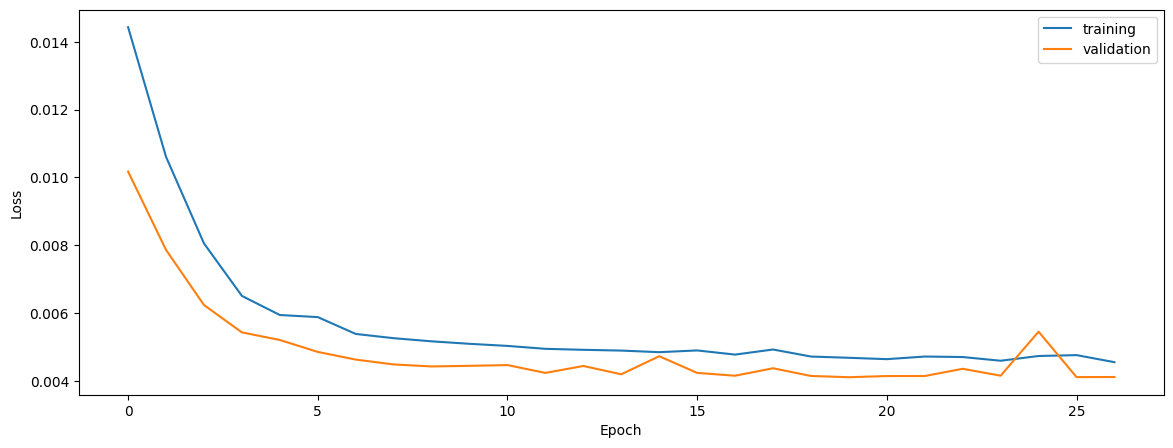

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7724953636721261
0.7748226238892886
0.6607206122954792


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7724953636721261
0.7748226238892886
0.6607206122954792


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7793622805600068
0.7891253767197344
0.6487358817070733


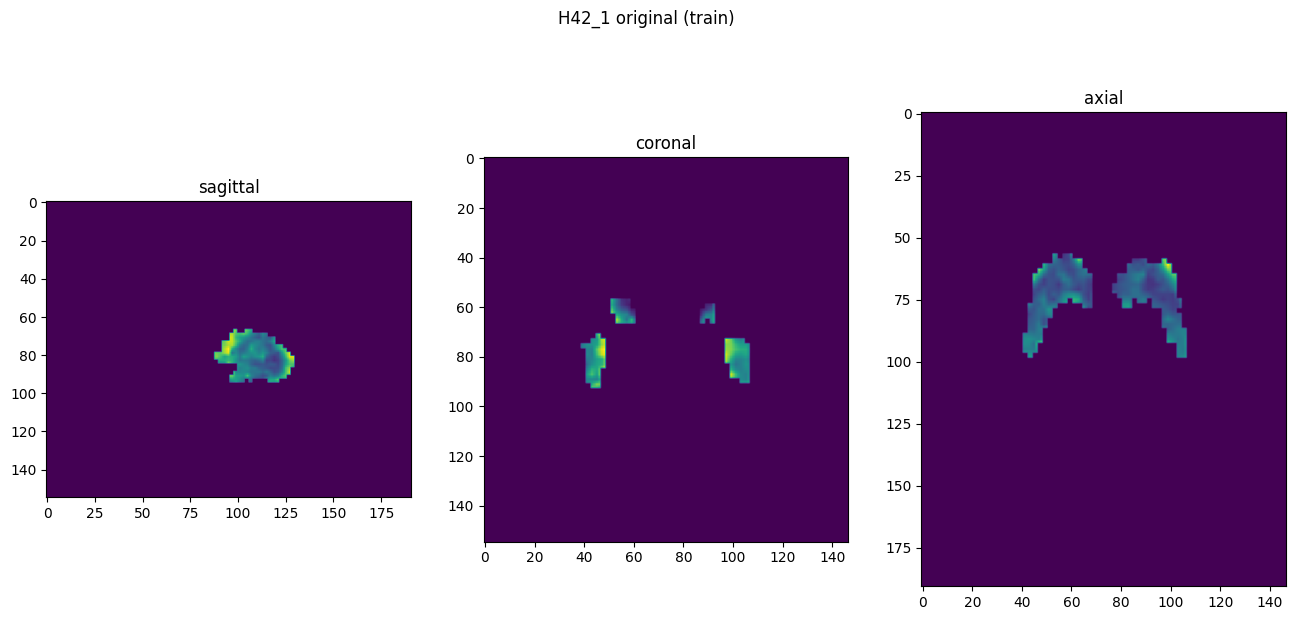

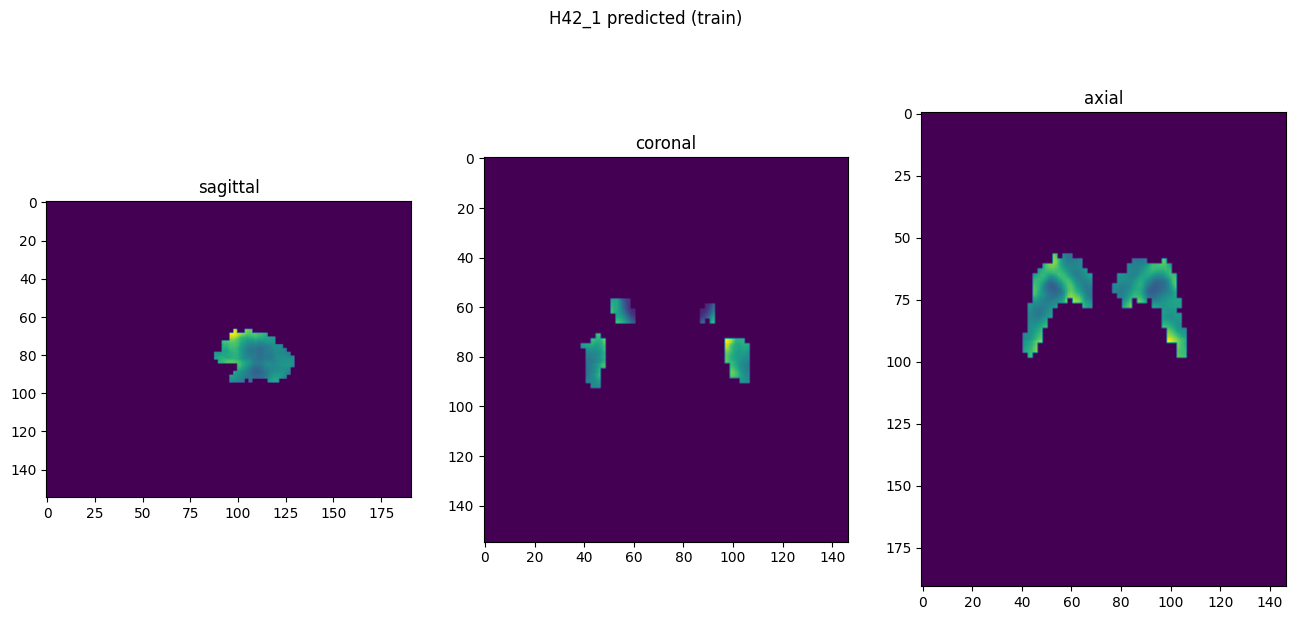

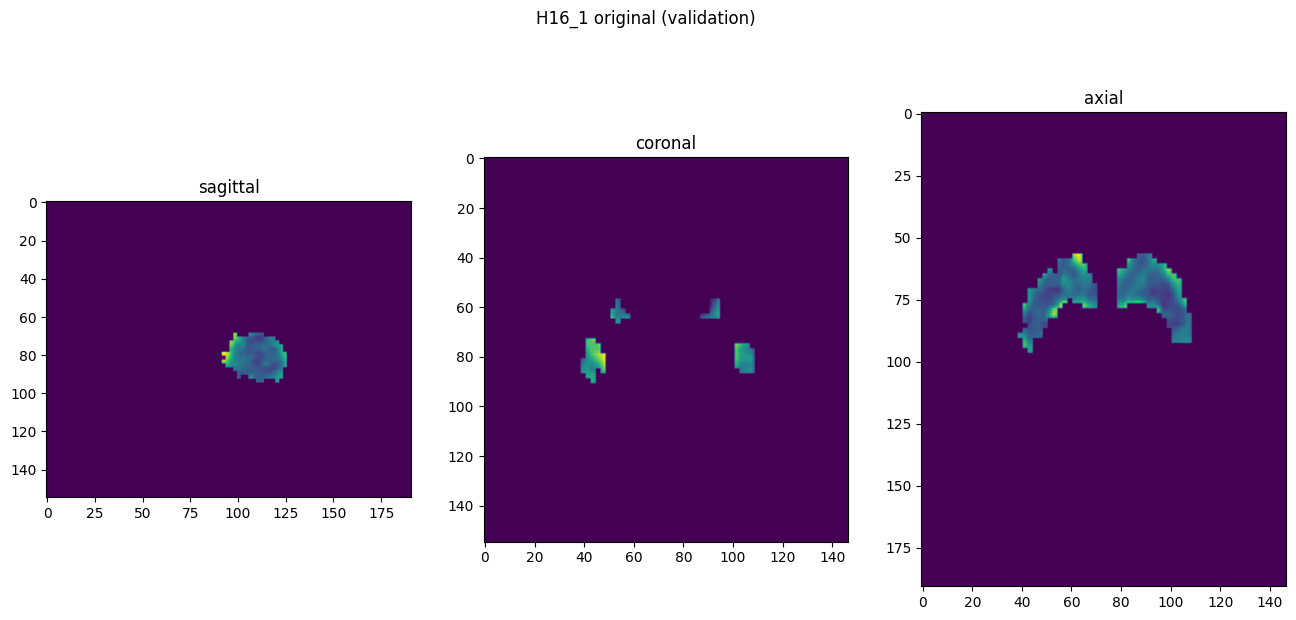

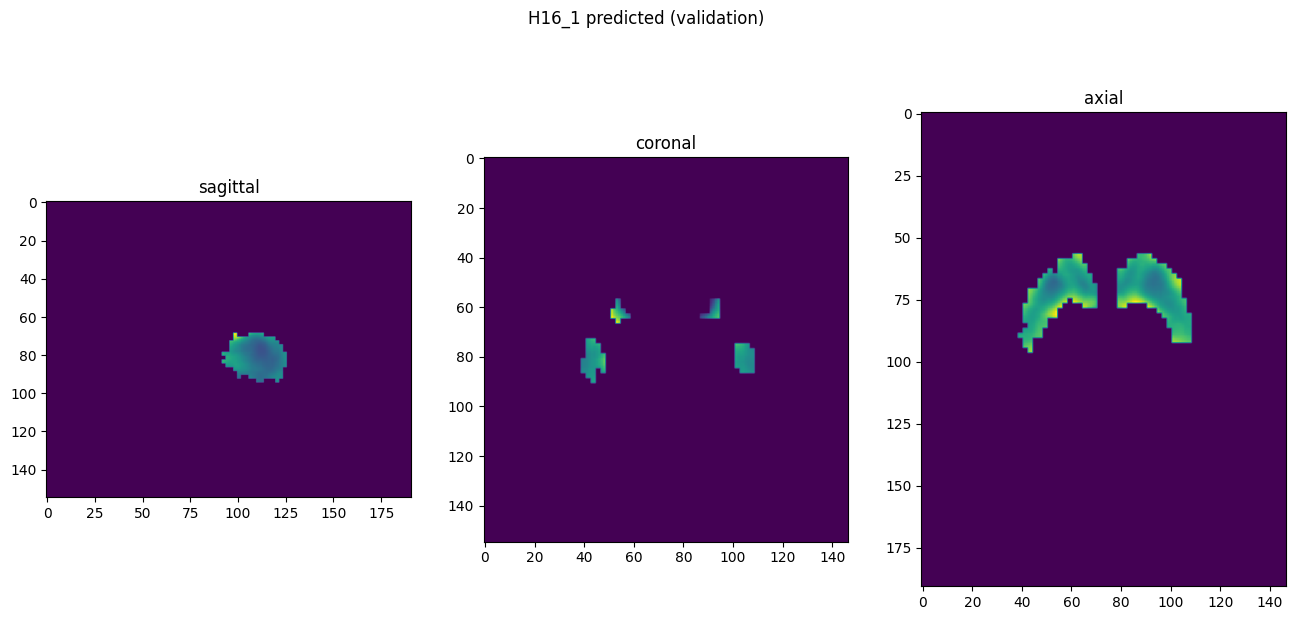

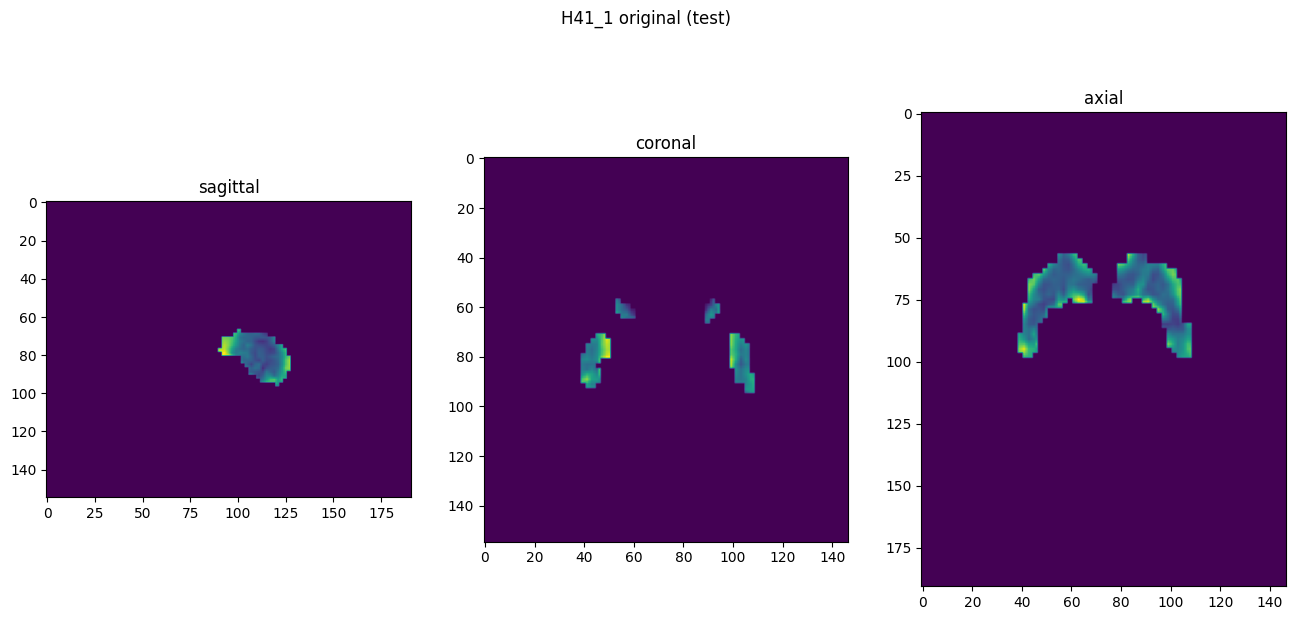

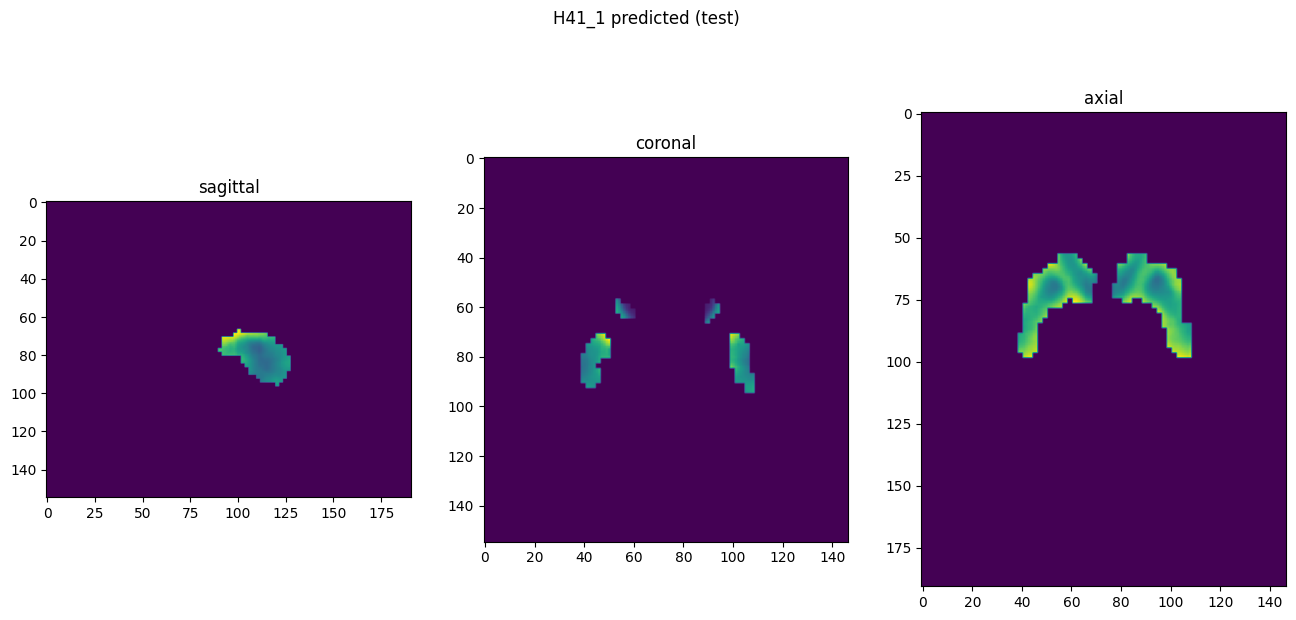

In [10]:
showResults(model, gen, threshold=None, background=False)